In [1]:
%load_ext autoreload
%autoreload 2 

%matplotlib inline

import torch
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
sns.set_context("notebook")

from sklearn import preprocessing
import pytorch_lightning as pl
from actpred.models import ActCNNSystem
from actpred.utils import get_threshold, get_stratified_split

from scipy.stats import spearmanr
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger, WandbLogger

pl.seed_everything(0)

Global seed set to 0


0

In [32]:
df = pd.read_csv("../data/SynAD_Glu_Filtered_ActivityCtrlStd_replicateactivities.csv")
df = df[df["AAseq"].str.len() == 40]
df = df.loc[df.Activity != 0.0]
df = df.loc[df.loc[:, ['AAseq', 'Activity']].drop_duplicates().index]

seqs = df["AAseq"].to_numpy()
activity = df["StdActivity"].to_numpy()
# thresh_std = 0.06018 # Bonferroni corrected p<0.001 threshold is 0.06018 (
thresh_std = 0.2457 # Weak Gcn4 central AD activity
y_bin = (activity >= thresh_std).astype(np.int64).reshape(-1, 1)
y_cont = df["StdActivity"].values.reshape(-1, 1)
scaler = preprocessing.StandardScaler().fit(y_cont)
y_cont = scaler.transform(y_cont)

# convert seqs to integer valued vectors
alphabet="ACDEFGHIKLMNPQRSTVWY"
aa_to_i = {aa:i for i, aa in enumerate(alphabet)}
i_to_aa = {i:aa for i, aa in enumerate(alphabet)}
X = np.asarray([[aa_to_i[aa] for aa in x] for x in seqs])

train, val, test, indices = get_stratified_split(X, y_bin, y_cont, as_tensor=True)
(X_train, y_bin_train, y_cont_train) = train
(X_val, y_bin_val, y_cont_val) = val
(X_test, y_bin_test, y_cont_test) = test
test_idx, val_idx = indices

In [ ]:
# Store train/test split in df
df["Set"] = "train"
df.loc[df.iloc[test_idx].index, "Set"] = "test"
df.loc[df.iloc[val_idx].index, "Set"] = "val"
# df.to_csv(fn.split(".csv")[0] + "_train_test_val.csv")

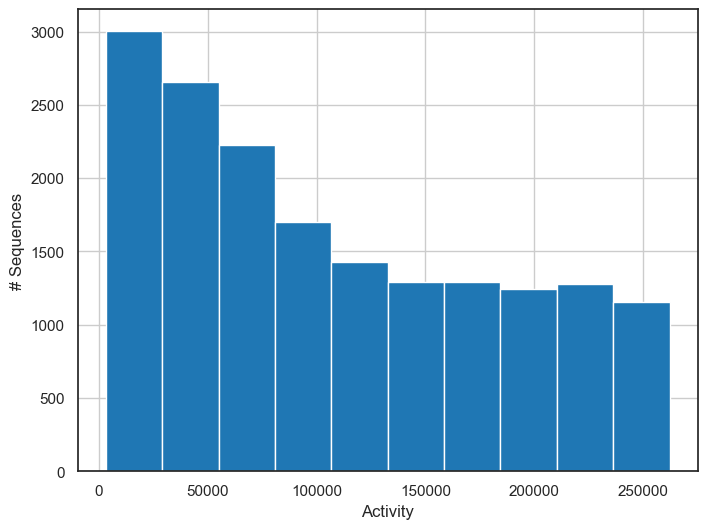

In [35]:
fig, ax = plt.subplots(figsize=(8,6))
df.Activity.hist(ax=ax)
ax.set(xlabel="Activity")
ax.set(ylabel="# Sequences")
sns.set_context('poster')

In [36]:
# Create Training and Validation Datasets
bs = 128
train_ds = TensorDataset(X_train, y_cont_train.to(torch.float))
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

val_ds = TensorDataset(X_val, y_cont_val.to(torch.float))
val_dl = DataLoader(val_ds, batch_size=bs)

### Train the model

In [37]:
# Train Model
kernel_size = 5
dilation = 3 
hidden = 64


model = ActCNNSystem(hidden, kernel_size, dilation, num_res_blocks=3, one_hot=True)
dirpath="models"
csv_logger = CSVLogger('logs')
checkpoint_callback = ModelCheckpoint(dirpath=dirpath, monitor="val_loss", filename="min_val_loss", save_last=True)
patience=10
early_stopping = EarlyStopping('val_loss', patience=patience)

trainer = pl.Trainer(accelerator="gpu", devices=1, callbacks=[checkpoint_callback, early_stopping], logger=[csv_logger], max_epochs=100)
trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=val_dl)

/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ActCNN           | 96.8 K
1 | loss_fn   | MSELoss          | 0     
2 | rmse      | MeanSquaredError | 0     
3 | pearsonr  | PearsonCorrCoef  | 0     
4 | spearmanr | SpearmanCorrCoef | 0     
-----------------------------------------------
96.8 K    Trainable params
0         Non-trainable params
96.8 K    Total params
0.387     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 18.85it/s]val_rmse 1.0164473056793213
val_pearsonr -0.06644535064697266
val_spearmanr -0.04433869943022728
                                                                           

/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 122/122 [00:02<00:00, 49.65it/s, loss=0.707, v_num=0]val_rmse 0.8076537251472473
val_pearsonr 0.5764119029045105
val_spearmanr 0.5904033184051514
Epoch 1: 100%|██████████| 122/122 [00:01<00:00, 83.84it/s, loss=0.543, v_num=0]val_rmse 0.7602342963218689
val_pearsonr 0.6803934574127197
val_spearmanr 0.6929487586021423
Epoch 2: 100%|██████████| 122/122 [00:01<00:00, 84.94it/s, loss=0.421, v_num=0]val_rmse 0.6911503076553345
val_pearsonr 0.7193455696105957
val_spearmanr 0.7323179244995117
Epoch 3: 100%|██████████| 122/122 [00:01<00:00, 85.74it/s, loss=0.378, v_num=0]val_rmse 0.8191006183624268
val_pearsonr 0.7203096747398376
val_spearmanr 0.7315714955329895
Epoch 4: 100%|██████████| 122/122 [00:01<00:00, 81.86it/s, loss=0.358, v_num=0]val_rmse 0.7095974087715149
val_pearsonr 0.7282024025917053
val_spearmanr 0.7412203550338745
Epoch 5: 100%|██████████| 122/122 [00:01<00:00, 80.54it/s, loss=0.338, v_num=0]val_rmse 1.1075838804244995
val_pearsonr 0.6954311728477478
v

In [38]:
# get best model and save it
model = model.load_from_checkpoint(checkpoint_callback.best_model_path)
model_path = "../adhunter/adhunter_1he_syn.pt"
torch.save(model.cpu().state_dict(), model_path)

/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [40]:
# Load model 
model = ActCNNSystem(hidden, kernel_size, dilation, num_res_blocks=3)
model.load_state_dict(torch.load(model_path))

/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


<All keys matched successfully>

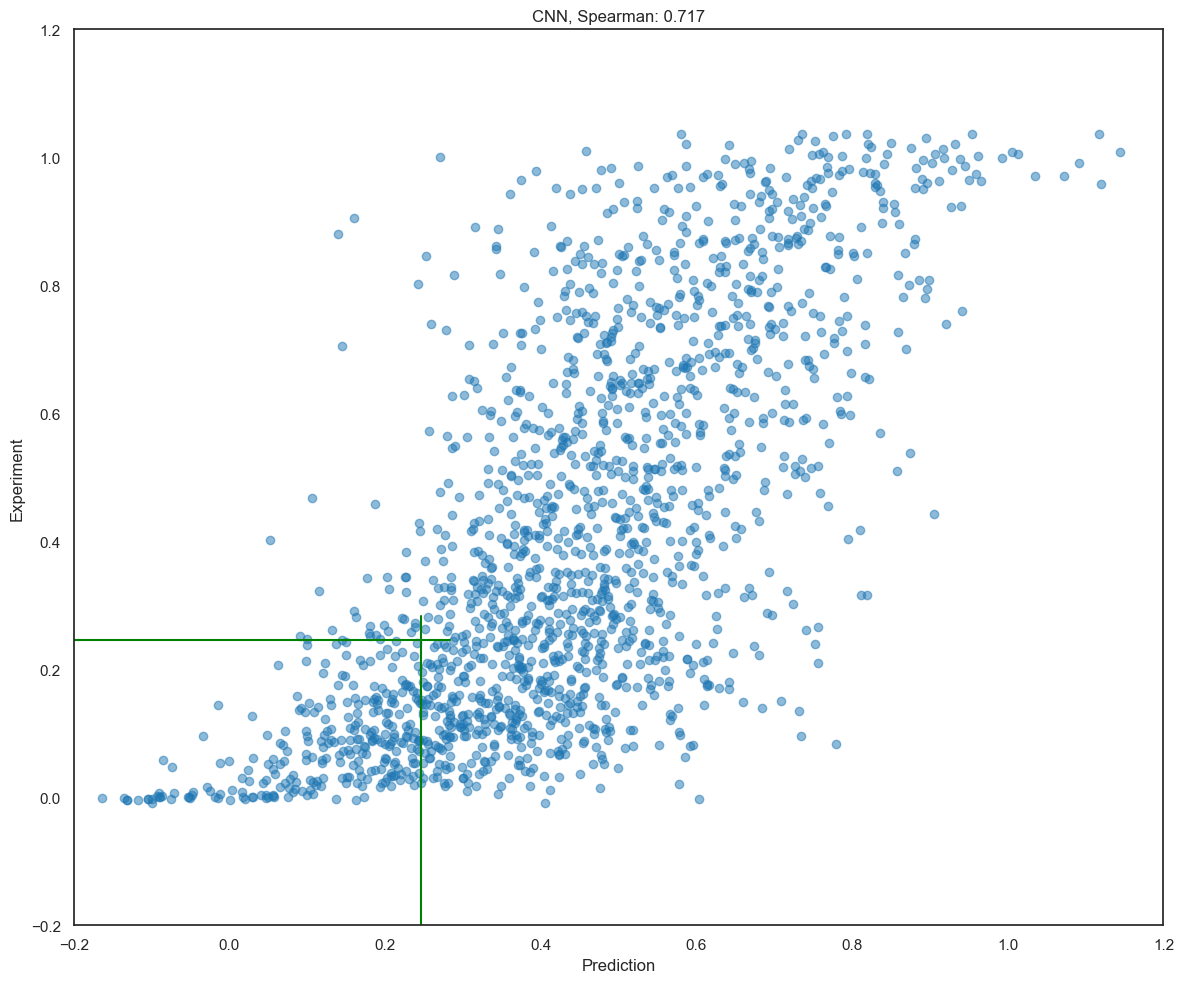

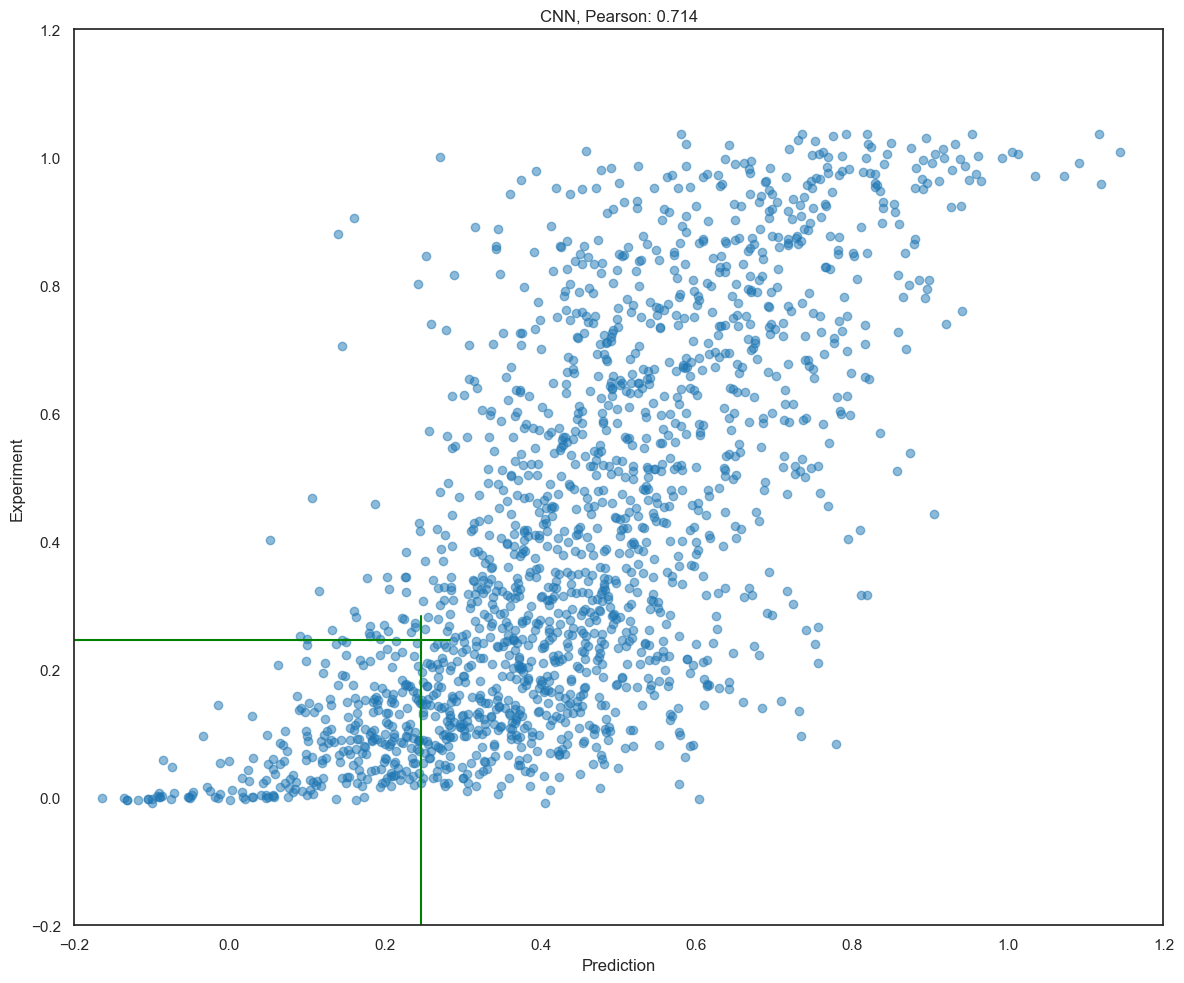

In [84]:
from scipy.stats import spearmanr, pearsonr

sns.set_style("white")
sns.set_context("notebook")

test_ds = TensorDataset(X_test, y_cont_test.to(torch.float))
test_dl = DataLoader(test_ds, batch_size=bs)

model.eval()
X_test, y_test = test_ds[:]
y_test = y_test.reshape(-1)
with torch.no_grad():
    y_test_hat = model(X_test).reshape(-1)
    y_test_hat = y_test_hat.detach().numpy()
    y_test = y_test.numpy()

best_thresh = get_threshold(y_bin_test, y_test_hat)
best_thresh_unscaled = scaler.inverse_transform(np.asarray([best_thresh]).reshape(-1, 1)).item()
y_test_hat_bin = (y_test_hat > best_thresh).astype(np.int32)

y_test_hat_unscaled = scaler.inverse_transform(y_test_hat.reshape(-1, 1)).reshape(-1)
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(-1)


def plot_corr(method="spearman"):
    fig, ax = plt.subplots(figsize=(12,10))
    ax.scatter(y_test_hat_unscaled, y_test_unscaled, alpha=0.5)
    if method == "spearman":
        corr = spearmanr(y_test_hat_unscaled, y_test_unscaled).correlation
        ax.set(xlabel="Prediction", ylabel="Experiment", title=f"CNN, Spearman: {corr:.3f}")
    elif method == "pearson":
        corr = pearsonr(y_test_hat_unscaled, y_test_unscaled).correlation
        ax.set(xlabel="Prediction", ylabel="Experiment", title=f"CNN, Pearson: {corr:.3f}")
    ax.set(xlim=(-.2, 1.2), ylim=(-.2, 1.2))
    plt.tight_layout()
    plt.axvline(x=thresh_std, c='green', ymax=0.345)
    plt.axhline(y=thresh_std, c='green', xmax=0.345)
    plt.show()

plot_corr("spearman")
plot_corr("pearson")

## DeepLIFT

In [62]:
from captum.attr import LayerDeepLift
X_ad = model.model.encode(torch.tensor(X[activity >= thresh_std]))
X_neg = model.model.encode(torch.tensor(X[activity < thresh_std]))
baseline_neg = X_neg.mean(dim=0).unsqueeze(0)

dl = LayerDeepLift(model, model.model.emb, multiply_by_inputs=True)
attr = dl.attribute(X_ad, baseline_neg, attribute_to_layer_input=True)

# X_ad.shape, X_neg.shape

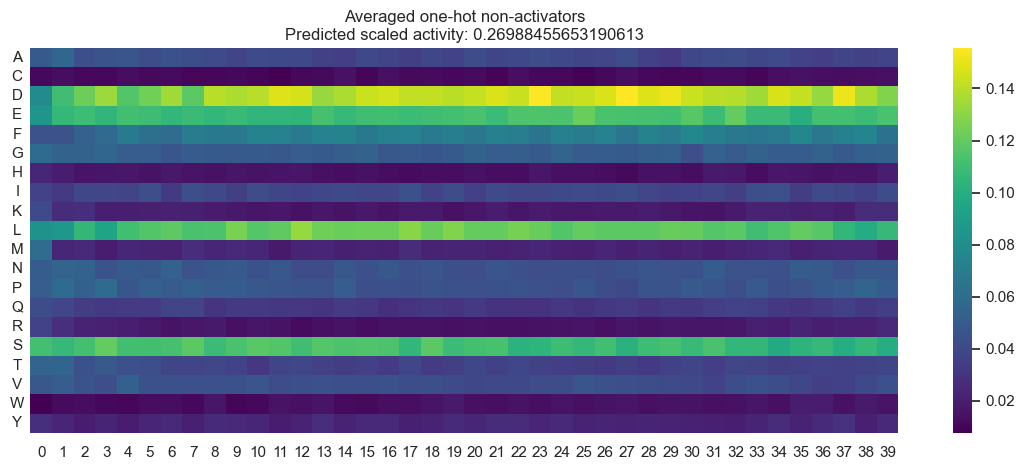

In [145]:
baseline_df = pd.DataFrame(baseline_neg.squeeze()).T
baseline_df.index = list(alphabet)
fig, ax = plt.subplots(figsize=(14, 5))
sns.heatmap(baseline_df, xticklabels=True, cmap='viridis', ax=ax)
ax.set_xticklabels(range(40), ha="center", rotation=0)
ax.set_yticklabels(ax.get_yticklabels(), ha="center", rotation=0)
ax.set_title(f"Averaged one-hot non-activators\nPredicted scaled activity: {model(baseline_neg).item()}")
plt.show()

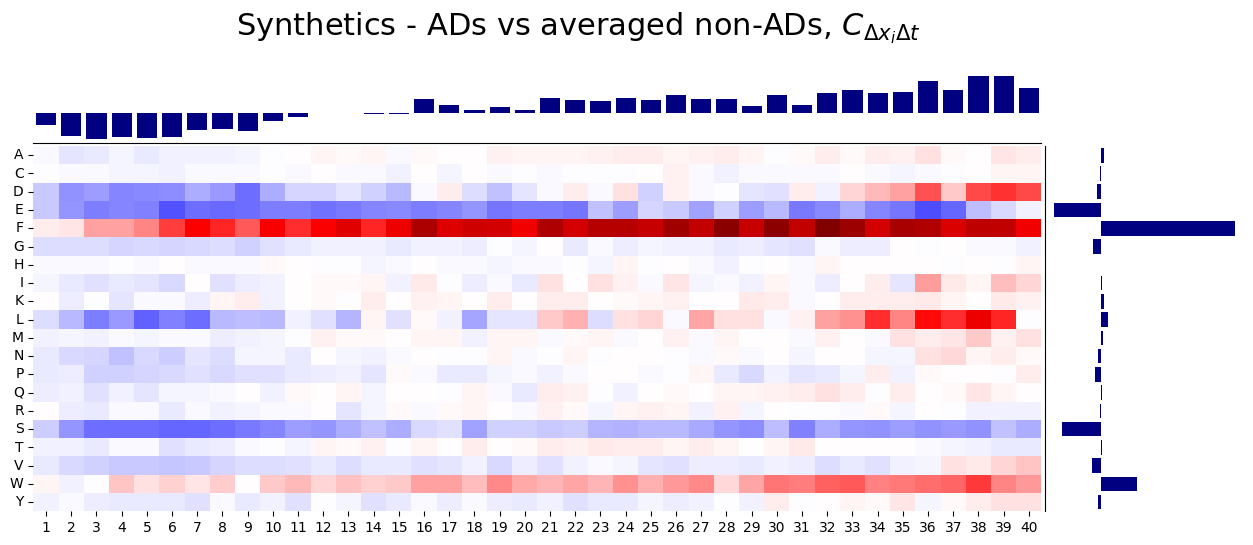

In [80]:
sns.reset_defaults()

def get_attr(dl, X, baseline, alphabet="ACDEFGHIKLMNPQRSTVWY"):
    attr = dl.attribute(X, baselines=baseline, attribute_to_layer_input=True).detach().numpy()
    attr_df = pd.DataFrame(attr.mean(axis=0)).T
    attr_df.index = list(alphabet)
    return attr_df

def plot_attr(df, ax=None, title=None, cmap="seismic"):
    if ax is None:
        fig, ax = plt.subplots(figsize=(14,5))
    sns.heatmap(df, cmap=cmap, center=0, ax=ax)
    ax.set_ylabel("AA")
    ax.set_xlabel("Position")
    ax.set_xticklabels(range(40), ha="center", rotation=0)
    ax.set_yticklabels(ax.get_yticklabels(), ha="center", rotation=0)
    if title is not None:
        ax.set_title(title)
    return ax
def joint_plot(attr_df, title=""):
    attr_df_melt = (attr_df
                        .rename_axis("AA")
                        .reset_index()
                        .melt(
                            id_vars=['AA'], 
                            var_name='pos', 
                            value_name='val'))

    D = 40
    H = 20
    df_ = attr_df_melt

    g = sns.jointplot(data=df_, x='AA', y='pos', kind='hist', bins=(D, H))
    g.ax_marg_y.cla()
    g.ax_marg_x.cla()
    sns.heatmap(
        data=df_['val'].to_numpy().reshape(D, H).T, 
        ax=g.ax_joint, cbar=False, cmap='seismic', 
        center=0)

    g.ax_marg_y.barh(np.arange(0.5, H), df_.groupby(['AA'])['val'].sum().to_numpy(), color='navy')
    g.ax_marg_x.bar(np.arange(0.5, D), df_.groupby(['pos'])['val'].sum().to_numpy(), color='navy')

    g.ax_joint.set_xticks(np.arange(0.5, D))
    g.ax_joint.set_xticklabels(range(1, D + 1), rotation=0)
    g.ax_joint.set_yticks(np.arange(0.5, H))
    g.ax_joint.set_yticklabels(list(alphabet), rotation=0)

    # remove ticks between heatmao and histograms
    g.ax_marg_x.tick_params(axis='x', bottom=False, labelbottom=False)
    g.ax_marg_y.tick_params(axis='y', left=False, labelleft=False)
    # remove ticks showing the heights of the histograms
    g.ax_marg_x.tick_params(axis='y', left=False, labelleft=False)
    g.ax_marg_y.tick_params(axis='x', bottom=False, labelbottom=False)

    g.fig.set_size_inches(14,5)  # jointplot creates its own figure, the size can only be changed afterwards
    # g.fig.subplots_adjust(hspace=0.3) # optionally more space for the tick labels
    g.fig.subplots_adjust(hspace=0.05, wspace=0.02)  # less spaced needed when there are no tick labels
    plt.suptitle(title, fontsize=22, y=1.1)
    plt.show()


attr_df = pd.DataFrame(attr.detach().numpy().mean(axis=0)).T
attr_df.index = list(alphabet)
joint_plot(attr_df, "Synthetics - ADs vs averaged non-ADs, $C_{\Delta{x_i}\Delta{t}}$")

Get multipliers

In [70]:
dl_m = LayerDeepLift(model, model.model.emb, multiply_by_inputs=False)
mdf = get_attr(dl_m, X_ad, baseline_neg)

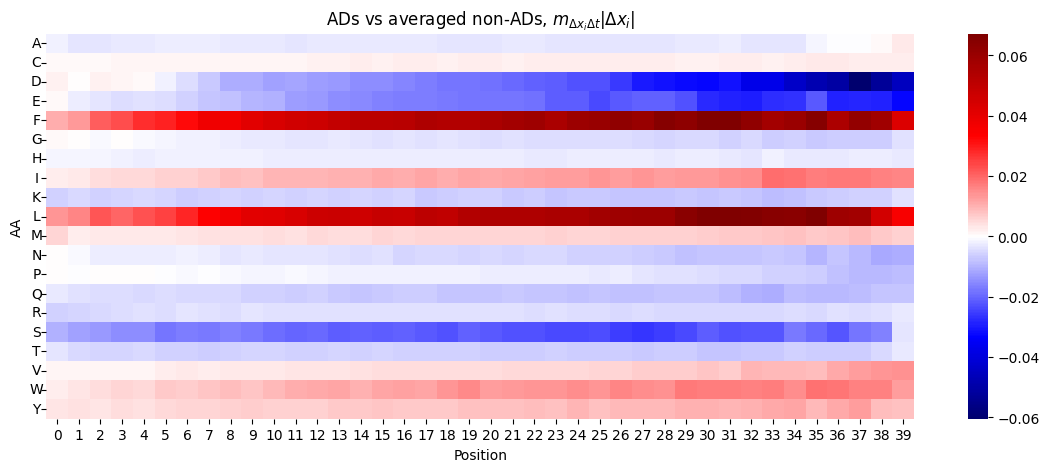

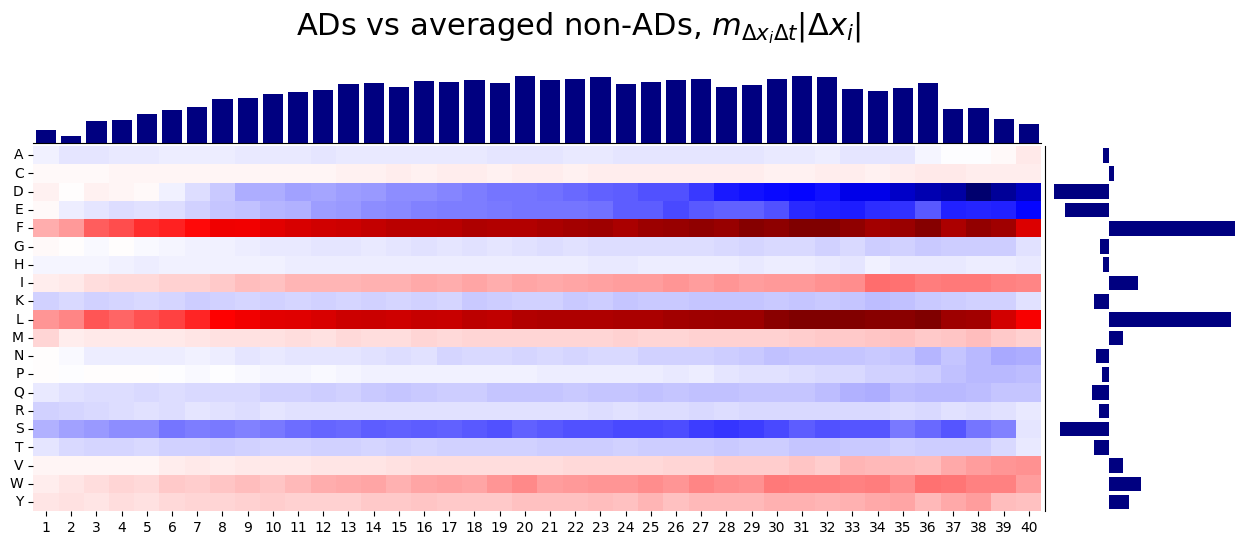

In [81]:
ad_dx = X_ad - baseline_neg
ad_m_abs_dx = mdf.values.T * np.abs(ad_dx.detach().numpy())
mean_attr = ad_m_abs_dx.mean(axis=0)

ad_attr_absdx = pd.DataFrame(mean_attr).T
ad_attr_absdx.index = list(alphabet)
plot_attr(ad_attr_absdx, title="ADs vs averaged non-ADs, $m_{\Delta{x_i}\Delta{t}}|\Delta{x_i}|$")
plt.show()
joint_plot(ad_attr_absdx, title="ADs vs averaged non-ADs, $m_{\Delta{x_i}\Delta{t}}|\Delta{x_i}|$")
plt.show()

In [ ]:
preds = model(torch.tensor(X))

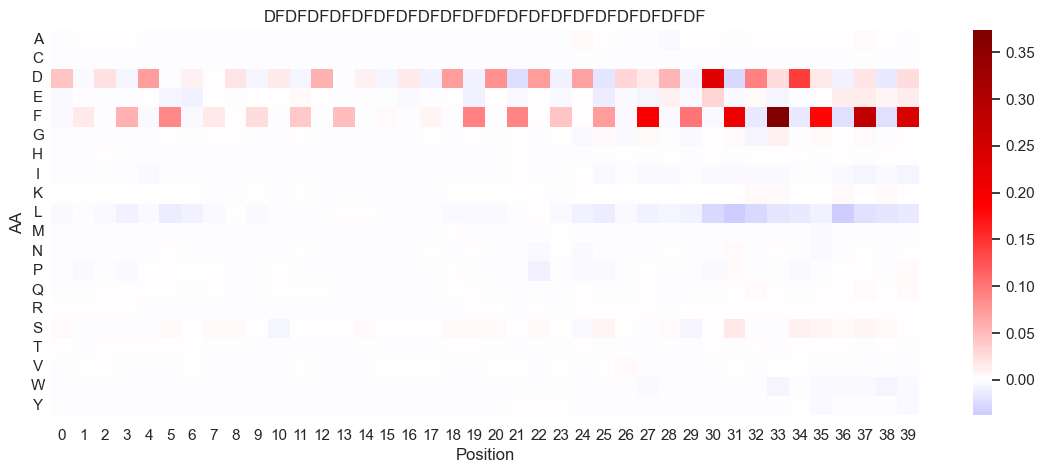

In [123]:
dl.attribute(model.model.encode("DF" * 20), baseline_neg, attribute_to_layer_input=True)
plot_attr(get_attr(dl, model.model.encode("DF" * 20), baseline_neg), title="DF" * 20)
plt.show()

In [139]:
eval = lambda s: print(f"{s}: {model(s).item()}")
# eval("F" * 40)
# eval("FD" * 20)
# eval("DF" * 20)
# eval("WD" * 20)
# eval("DS" * 20)
# eval("AF" * 20)
for i in alphabet:
    eval(f"{i}F" * 20)

AFAFAFAFAFAFAFAFAFAFAFAFAFAFAFAFAFAFAFAF: -3.027695894241333
CFCFCFCFCFCFCFCFCFCFCFCFCFCFCFCFCFCFCFCF: -3.114452600479126
DFDFDFDFDFDFDFDFDFDFDFDFDFDFDFDFDFDFDFDF: 3.255514144897461
EFEFEFEFEFEFEFEFEFEFEFEFEFEFEFEFEFEFEFEF: -0.20682060718536377
FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF: -4.205891132354736
GFGFGFGFGFGFGFGFGFGFGFGFGFGFGFGFGFGFGFGF: -0.5537911653518677
HFHFHFHFHFHFHFHFHFHFHFHFHFHFHFHFHFHFHFHF: -2.5397608280181885
IFIFIFIFIFIFIFIFIFIFIFIFIFIFIFIFIFIFIFIF: -4.581042289733887
KFKFKFKFKFKFKFKFKFKFKFKFKFKFKFKFKFKFKFKF: -3.2513444423675537
LFLFLFLFLFLFLFLFLFLFLFLFLFLFLFLFLFLFLFLF: -4.26558780670166
MFMFMFMFMFMFMFMFMFMFMFMFMFMFMFMFMFMFMFMF: -3.5144002437591553
NFNFNFNFNFNFNFNFNFNFNFNFNFNFNFNFNFNFNFNF: -0.7763769626617432
PFPFPFPFPFPFPFPFPFPFPFPFPFPFPFPFPFPFPFPF: 1.743281602859497
QFQFQFQFQFQFQFQFQFQFQFQFQFQFQFQFQFQFQFQF: -1.2071037292480469
RFRFRFRFRFRFRFRFRFRFRFRFRFRFRFRFRFRFRFRF: -4.0557451248168945
SFSFSFSFSFSFSFSFSFSFSFSFSFSFSFSFSFSFSFSF: -1.1786448955535889
TFTFTFTFTFTFTFTFT

Does replacing D's with F's increase activity (since Ds are so negative wrt $c_i$)

In [132]:
X_d2f = torch.stack(df["AAseq"].str.replace("D", "F").apply(model.model.encode).tolist()).squeeze()
preds_d2f = model(X_d2f)

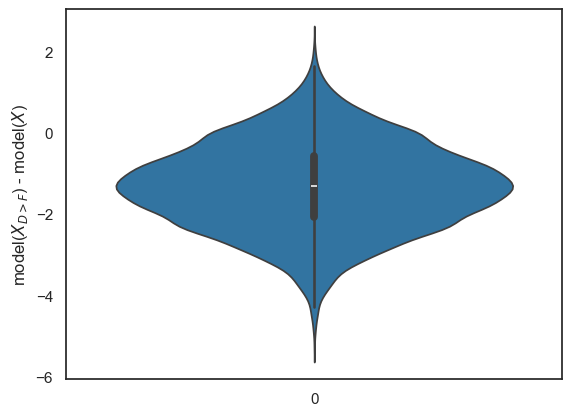

In [137]:
sns.violinplot((preds_d2f - preds).detach().numpy())
plt.ylabel("model($X_{D > F}$) - model($X$)")
plt.show()

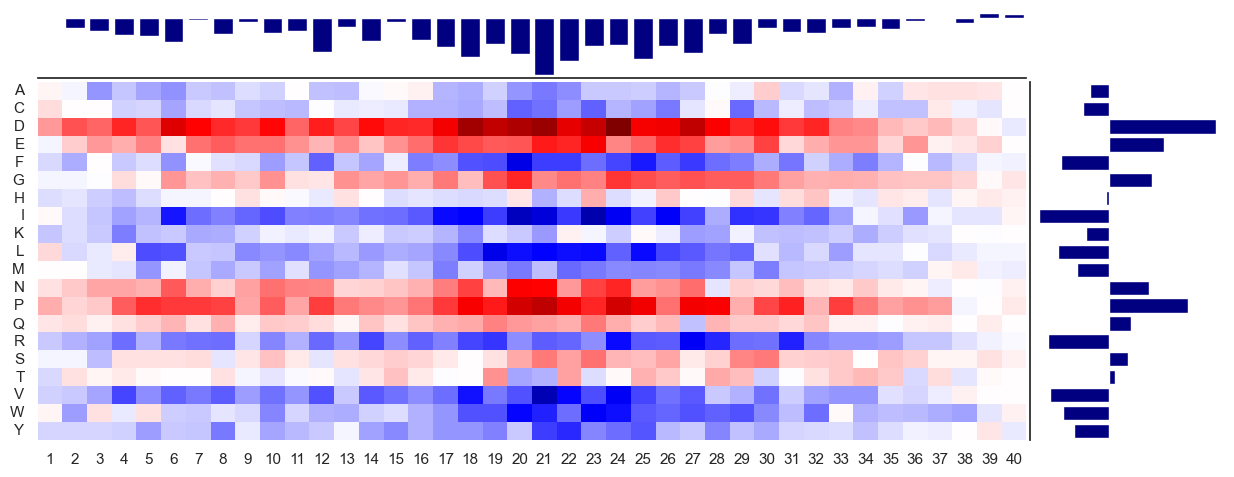

In [ ]:
joint_plot(get_attr(dl_m, model.model.encode("F" * 40), baseline_neg))
plt.show()

In [154]:
df["State Size"].value_counts()

State Size
5.0    3383
1.0    3364
3.0    3355
2.0    3338
4.0    3330
Name: count, dtype: int64